In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import shutil

In [114]:
RESUME = None # path to checkpoint
EXPORT = 'model.pth'
BATCH_SIZE = 8
TEST_SIZE = 0.8 
EPOCH = 100
LR = 1e-3
SIGMA = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [115]:
class regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(1, 5),
            nn.Sigmoid(),
            nn.Linear(5, 10),
            nn.Sigmoid(),
            nn.Linear(10, 5),
            nn.Sigmoid(),
            nn.Linear(5, 1)
        )
        self.reset_parameters()

    def forward(self,x):
        x = self.linear(x)
        return x
    def reset_parameters(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)

In [116]:
class dataset(Dataset):
    def __init__(self, data : list):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx][0],dtype=torch.float32).reshape(-1,1)
        y = torch.tensor(self.data[idx][1],dtype=torch.float32).reshape(-1,1)
        return x, y

In [117]:
def normalize(data: np.array):
    return (data - data.mean()) / data.std()

In [118]:
def plot_train_test(train: np.array, test: np.array):
    '''
    plot the train and test data
    '''
    plt.scatter(train[:,0], train[:,1], label='train', color='r')
    plt.scatter(test[:,0], test[:,1], label='test', color = 'b')
    plt.legend()
    plt.show()

def plot_loss_curve(history: list):
    plt.cla()
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('test_loss') for x in history]
    plt.plot(train_losses, '-bx',label='train')
    plt.plot(val_losses, '-rx',label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.legend()
    plt.savefig('loss_curve.png')

In [119]:
def train(model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer):
    history = []
    start_epoch = 1

    model.train()
    for epoch in range(start_epoch,EPOCH + 1):
        train_loss = 0
        result = {'train_loss': [], 'test_loss': []}
        print('Epoch: {}'.format(epoch))
        print('learning rate: {:.6f}'.format(optimizer.param_groups[0]['lr']))
        for x,y in (train_dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_dataloader) # average loss per batch
        
        model.eval()
        with torch.no_grad():
            # compute validation loss 
            valid_loss = 0
            for x,y in test_dataloader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                loss = criterion(output, y)
                valid_loss += loss.item()
            valid_loss = valid_loss / len(test_dataloader) # average loss per batch
            

        result['train_loss'].append(train_loss)
        result['test_loss'].append(valid_loss)
        
        print('Train Loss: {:.4f}'.format(train_loss))
        print('Test Loss: {:.4f}'.format(valid_loss))
        history.append(result)

        plot_loss_curve(history)

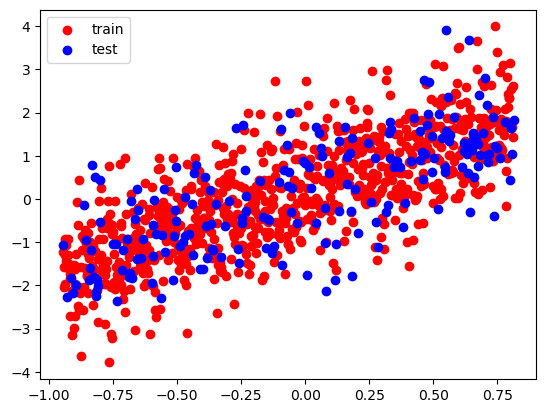

Epoch: 1
learning rate: 0.001000
Train Loss: 1.8224
Test Loss: 1.7454
Epoch: 2
learning rate: 0.001000
Train Loss: 1.7406
Test Loss: 1.6990
Epoch: 3
learning rate: 0.001000
Train Loss: 1.7221
Test Loss: 1.6833
Epoch: 4
learning rate: 0.001000
Train Loss: 1.7117
Test Loss: 1.6693
Epoch: 5
learning rate: 0.001000
Train Loss: 1.6996
Test Loss: 1.6554
Epoch: 6
learning rate: 0.001000
Train Loss: 1.6813
Test Loss: 1.6345
Epoch: 7
learning rate: 0.001000
Train Loss: 1.6546
Test Loss: 1.6032
Epoch: 8
learning rate: 0.001000
Train Loss: 1.6151
Test Loss: 1.5549
Epoch: 9
learning rate: 0.001000
Train Loss: 1.5578
Test Loss: 1.4904
Epoch: 10
learning rate: 0.001000
Train Loss: 1.4777
Test Loss: 1.4018
Epoch: 11
learning rate: 0.001000
Train Loss: 1.3744
Test Loss: 1.2902
Epoch: 12
learning rate: 0.001000
Train Loss: 1.2548
Test Loss: 1.1739
Epoch: 13
learning rate: 0.001000
Train Loss: 1.1289
Test Loss: 1.0676
Epoch: 14
learning rate: 0.001000
Train Loss: 1.0195
Test Loss: 0.9851
Epoch: 15
learn

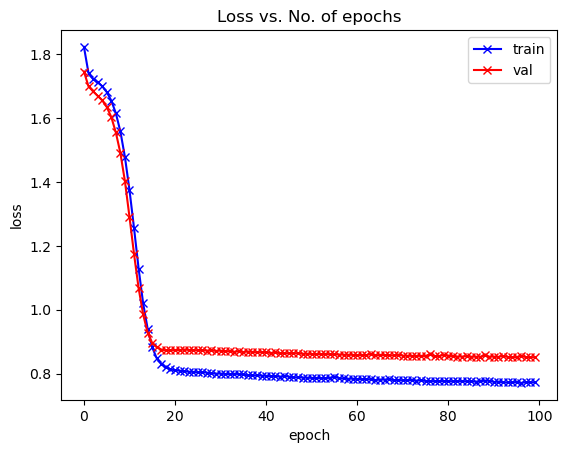

In [120]:
def func(x):
    return 2*x + 1 + random.gauss(mu = 0,sigma=SIGMA)
data = np.array([(x,func(x)) for x in np.linspace(start=-10,stop=10,num=1000)])
data = normalize(data)
# split into train and test randomly
np.random.shuffle(data)
train_dataset = data[:int(TEST_SIZE*len(data))]
test_dataset = data[int(TEST_SIZE*len(data)):]
plot_train_test(train_dataset,test_dataset)
train_dataset = dataset(train_dataset)
test_dataset = dataset(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

model = regression().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
history = []
train(model,train_dataloader,test_dataloader,criterion,optimizer)